In [1]:
import json 
# sort tweets into Washington vs. Massachusetts
tweets_WA = []
tweets_MA = []
f = 'ECE219_tweet_data/tweets_#superbowl.txt'
for line in open(f, 'r'):
    tweet = json.loads(line)
    
    loc = tweet['tweet']['user']['location']
    if " WA" in loc or ("Washington" in loc and "DC" not in loc and "D.C." not in loc):
        tweets_WA.append(tweet['tweet']['text'])
    elif " MA" in loc or "Massachusetts" in loc:
        tweets_MA.append(tweet['tweet']['text'])

In [2]:
print(len(tweets_WA)) 
print(len(tweets_MA)) 

12548
13687


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
        

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1045)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1045)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1045)>


False

In [4]:
# Convert tweets to TF-IDF
import numpy as np
import random
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation

def build_vectorizer(min_df):
    wnl = nltk.wordnet.WordNetLemmatizer()
    stop_words_skt = text.ENGLISH_STOP_WORDS
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
    
    analyzer = CountVectorizer().build_analyzer()

    def lemmatize_sent(list_word):
        # Text input is string, returns array of lowercased strings(words).
        return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
                for word, tag in pos_tag(list_word)]
            
    def stem_rmv_punc(doc):
        return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

    def penn2morphy(penntag):
        """ Converts Penn Treebank tags to WordNet. """
        morphy_tag = {'NN':'n', 'JJ':'a',
                'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'

    return CountVectorizer(min_df=min_df, analyzer=stem_rmv_punc, stop_words='english')

def vectorize_data(data1, data2, min_df=3):
    train_dataset = data1 + data2
    Bin_Target_Train = np.zeros(len(train_dataset))
    Bin_Target_Train[0:len(data1)] = 1
    c = list(zip(train_dataset, Bin_Target_Train))
    random.shuffle(c)
    train_dataset, Bin_Target_Train = zip(*c)

    count_vect = build_vectorizer(min_df=min_df)

    X_train_counts = count_vect.fit_transform(train_dataset)
    #X_test_counts = count_vect.transform(test_dataset.data)

    # Report the shape of the TF-IDF matrices of the train and test subsets respectively**
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    #X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    return X_train_tfidf, Bin_Target_Train

X_train_tfidf, Bin_Target_Train = vectorize_data(tweets_WA, tweets_MA)

In [5]:
print(X_train_tfidf.shape)

(26235, 5448)


In [6]:
# Dimension Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

def LSI_(X_train_tfidf, n=50):

    svd = TruncatedSVD(n_components=n, random_state=0)
    
    # print U.shape, Sigma.shape, VT.shape
    X_train_r = svd.fit_transform(X_train_tfidf)
    
    return X_train_r


In [7]:
#  Helper Functions
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
import itertools
import matplotlib.pyplot as plt

def print_metrics(y_true, y_predict, options= "binary" ):
    print('Accuracy: %f' % accuracy_score(y_true, y_predict))
    print('Precision: %f'% precision_score(y_true, y_predict,average = options))
    print('Recall: %f'% recall_score(y_true, y_predict,average = options))
    print('F1-score: %f' % f1_score(y_true, y_predict,average = options))
    

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label='area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(15)
        
def fit_predict_and_plot_roc1(sv_instance, test_data, test_label):
 
    if hasattr(sv_instance, 'decision_function'):
        prob_score = sv_instance.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = sv_instance.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:, 1])

    plot_roc(fpr, tpr)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Best r: 200


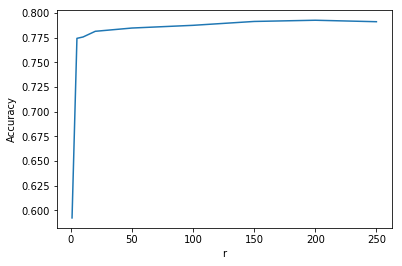

In [14]:
# Logistic Classifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, f1_score
from sklearn.model_selection import KFold, train_test_split


def logistic_classifier(X, y, plot=False):
    c_values = 10.0 ** np.array(range(-3,4)) 
    accuracies = []
    precisions = []
    recalls = []
    
    for c in c_values:
        kf = KFold(n_splits=10, shuffle = True)
        acc_total = 0
        recall_total = 0
        prec_total = 0
    
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = LogisticRegression(C=c, solver='liblinear').fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            acc_total += accuracy_score(y_test, y_predict)
            recall_total += recall_score(y_test, y_predict)
            prec_total += precision_score(y_test, y_predict)
        acc_total = acc_total / 10.0
        recall_total = recall_total / 10.0
        prec_total = prec_total / 10.0
        accuracies.append(acc_total)
        precisions.append(prec_total)
        recalls.append(recall_total)
    best_c = np.argmax(accuracies)
    
    if plot:
        print("Best C: %f" % c_values[best_c])
        print('Accuracy: %f' % accuracies[best_c])
        print('Precision: %f' % precisions[best_c])
        print('Recall: %f' % recalls[best_c])
        plt.figure()
        plt.semilogx(c_values,  accuracies)
        plt.xlabel('C')
        plt.ylabel('Accuracy')
        plt.show() 
        # Plot ROC and Confusion matrix with best C
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
        clf = LogisticRegression(C=c_values[best_c], solver='liblinear').fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        fit_predict_and_plot_roc1(clf, X_test, y_test)
        cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
        plt.figure()
        class_names = ['Massachusetts', 'Washington']
        plot_confusion_matrix(cnf_matrix, classes=class_names,  normalize=True,
                                      title='Logistic Regression Confusion matrix')
        plt.show()
    return accuracies[best_c]
    
y = np.array(Bin_Target_Train)
r_values = [1, 5, 10, 20, 50,100,150,200,250]
accs = []
for r in r_values:
    X = LSI_(X_train_tfidf, r)
    accs.append(logistic_classifier(X, y))
best_r = r_values[np.argmax(accs)]
print("Best r: %d" % best_r)
plt.plot(r_values, accs)
plt.xlabel("r")
plt.ylabel("Accuracy")
plt.show()


Best C: 100.000000
Accuracy: 0.792453
Precision: 0.882421
Recall: 0.653084


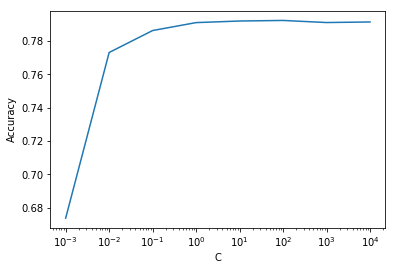

/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Normalized confusion matrix
[[0.91887906 0.08112094]
 [0.35488959 0.64511041]]


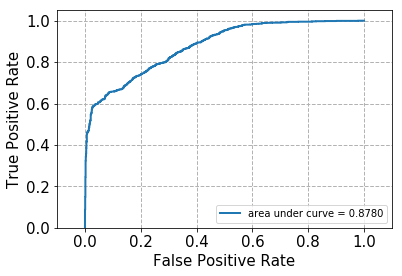

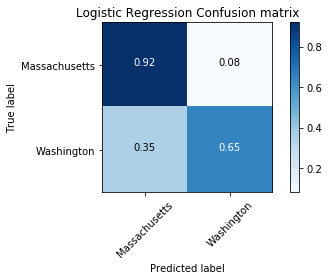

0.7924528735017621

In [16]:
best_r = 200
X = LSI_(X_train_tfidf, best_r)
logistic_classifier(X, y, True)

/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best C: 100.000000
Accuracy: 0.791310
Precision: 0.892104
Recall: 0.641773


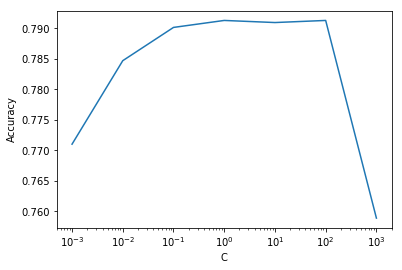

/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Normalized confusion matrix
[[0.91285081 0.08714919]
 [0.33543307 0.66456693]]


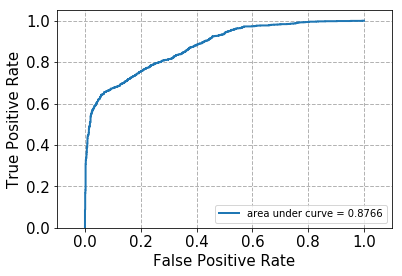

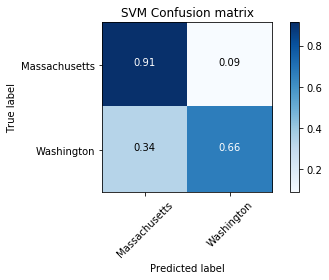

0.7913095953479073

In [17]:
# SVM
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, f1_score
from sklearn.model_selection import KFold, train_test_split


def SVM_classifier(X, y, plot=False):
    c_values = 10.0 ** np.array(range(-3,4)) # 10^-3 to 10^3
    accuracies = []
    precisions = []
    recalls = []
    
    for c in c_values:
        kf = KFold(n_splits=10, shuffle = True)
        acc_total = 0
        recall_total = 0
        prec_total = 0
    
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = LinearSVC(C=c).fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            acc_total += accuracy_score(y_test, y_predict)
            recall_total += recall_score(y_test, y_predict)
            prec_total += precision_score(y_test, y_predict)
        acc_total = acc_total / 10.0
        recall_total = recall_total / 10.0
        prec_total = prec_total / 10.0
        accuracies.append(acc_total)
        precisions.append(prec_total)
        recalls.append(recall_total)
    best_c = np.argmax(accuracies)
    print("Best C: %f" % c_values[best_c])
    print('Accuracy: %f' % accuracies[best_c])
    print('Precision: %f' % precisions[best_c])
    print('Recall: %f' % recalls[best_c])
    
    if plot:
        plt.figure()
        plt.semilogx(c_values,  accuracies)
        plt.xlabel("C")
        plt.ylabel("Accuracy")
        plt.show() 
        # Plot ROC and Confusion matrix with best C
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
        clf = LinearSVC(C=c_values[best_c], class_weight='balanced').fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        #print_metrics(y_test, y_pred)
        fit_predict_and_plot_roc1(clf, X_test, y_test)
        cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
        plt.figure()
        class_names = ['Massachusetts', 'Washington']
        plot_confusion_matrix(cnf_matrix, classes=class_names,  normalize=True,
                                      title='SVM Confusion matrix')
        plt.show()
    return accuracies[best_c]

best_r = 200
X = LSI_(X_train_tfidf, best_r)
SVM_classifier(X, y, True)

200
Accuracy: 0.692013
Precision: 0.683062
Recall: 0.665051


/Users/meganwilliams/p3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Normalized confusion matrix
[[0.73163636 0.26836364]
 [0.32906325 0.67093675]]


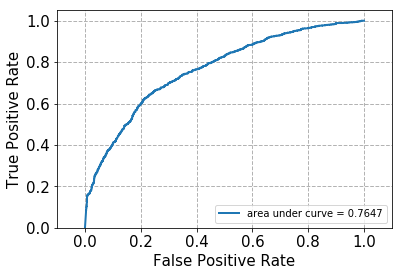

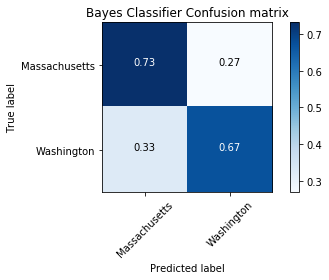

In [11]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

def Bayes_classifier(X, y):
    kf = KFold(n_splits=10, shuffle = True)
    acc_total = 0
    recall_total = 0
    prec_total = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = GaussianNB().fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        acc_total += accuracy_score(y_test, y_predict)
        recall_total += recall_score(y_test, y_predict)
        prec_total += precision_score(y_test, y_predict)
    
    print('Accuracy: %f' % (acc_total / 10.0))
    print('Precision: %f' % (prec_total / 10.0))
    print('Recall: %f' % (recall_total / 10.0 ))
    
    # Plot
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
    GaussianNB().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    fit_predict_and_plot_roc1(clf, X_test, y_test)
    cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    plt.figure()
    class_names = ['Massachusetts', 'Washington']
    plot_confusion_matrix(cnf_matrix, classes=class_names,  normalize=True, title='Bayes Classifier Confusion matrix')
    plt.show()
    
best_r = 200
X = LSI_(X_train_tfidf, best_r)
Bayes_classifier(X,y)